### 🖋️ Understanding the Location of Meaningful Information in Long Sentences

In this notebook, we develop and evaluate **deep learning–based text classification models** to investigate where meaningful information is concentrated within long sentences. Multiple **CNN architectures** are trained using **GloVe word embeddings** on the Kaggle dataset:  
https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text

The main objective is to determine **which sentence positions contribute most significantly** to the classification of text as **human-written** or **AI-generated**.

The classification task is defined as:

- **0 → Human-written text**  
- **1 → AI-generated text**

---


### 📦 Imports

In the following code cell, we will import all the necessary packages that will be used throughout this notebook.  
These include libraries for data handling, visualization, and model development.


In [1]:
import torch
import random
import warnings
import seaborn as sns
import os
import json
import re
import time
import html

from collections import Counter, defaultdict
from helperfns.tables import tabulate_data
from pigmenta import PALETTES
from helperfns.visualization import plot_wordcloud, plot_classification_report, plot_complicated_confusion_matrix
from helperfns.utils import hms_string
from torch import nn
from sklearn.utils import resample
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.9.0+cu126
numpy:  2.3.3
pandas:  2.3.3


### 🎲 Setting Seeds

In the following code cell, we will set a fixed seed value for all random operations to ensure **reproducibility** of the results.  
This helps guarantee that the model produces consistent outputs every time the notebook is run.


In [2]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### 🖥️ Device

In the following code cell, we will check for the availability of a **GPU** device and use it if possible.  
Utilizing a GPU can significantly accelerate model training and computations `(Khairy et al., 2020)`.


### Refs:

1. Khairy, M., Shen, Z., Aamodt, T.M. and Rogers, T.G., 2020, May. Accel-sim: An extensible simulation framework for validated gpu modeling. In 2020 ACM/IEEE 47th Annual International Symposium on Computer Architecture (ISCA) (pp. 473-486). IEEE.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In the next code cell, we will use the **Kaggle API** to download the dataset required for this study.

> Dataset: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text

Make sure that your Kaggle API credentials (`kaggle.json`) are properly configured before running the download command.

In [69]:
with open('C://Users//crisp//Downloads//kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']
!kaggle datasets download shanegerami/ai-vs-human-text --unzip -q


Dataset URL: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text
License(s): other


### 📂 Dataset

Next, we load the dataset into a **Pandas DataFrame** using the `read_csv()` function.  
The file `AI_Human.csv` contains the text data along with their corresponding class labels.

**Objective:**  
To analyze the position of meaningful information within long texts—specifically whether key signals (**AI** or **Human**) tend to appear at the **beginning**, **middle**, or **end** of essays.


In [70]:
dataframe = pd.read_csv('AI_Human.csv')
dataframe.head(2)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0


In the following code cell we are going to remove the `Na` values and null values as a way of cleaning the dataset.

In [71]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()
dataframe.generated = dataframe.generated.astype(np.uint32)
dataframe.head(2)

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0


Next we are going to check the size of the dataset after this modification.

In [72]:
print(f"The dataset size is: {len(dataframe):,}")

The dataset size is: 487,235


### 🧹 Data Cleaning

The dataset contains a total of `487,235` samples labeled as **AI** and **Human**.

Before filtering out shorter texts, it is important to properly clean and preprocess the data. This step helps remove noise, normalize the text, and ensure consistency for downstream modeling.

The following function is used to perform the cleaning process:


In [73]:
MENTION_HASHTAG_RE = re.compile(r"(@|#)([A-Za-z0-9_]+)")
EMAIL_RE = re.compile(r"([A-Za-z0-9]+[._-])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Za-z]{2,})+")
URL_RE = re.compile(r"https?://\S+|www\.\S+")
HTML_TAG_RE = re.compile(r"<.*?>")
DIGIT_RE = re.compile(r"\d+")
PUNCT_RE = re.compile(r"[^\w\s']")
SPACE_RE = re.compile(r"\s+")

def clean_sentence(sent: str, lower: bool = True) -> str:
    sent = html.unescape(sent)
    if lower:
        sent = sent.lower()
    sent = HTML_TAG_RE.sub(" ", sent)
    sent = MENTION_HASHTAG_RE.sub(" ", sent)
    sent = EMAIL_RE.sub(" ", sent)
    sent = URL_RE.sub(" ", sent)
    sent = DIGIT_RE.sub(" ", sent)
    sent = PUNCT_RE.sub(" ", sent)
    sent = SPACE_RE.sub(" ", sent).strip()
    return sent

print("Unclean Example: ", dataframe.iloc[10].text)
print("\n\nClean Example: ", clean_sentence(dataframe.iloc[10].text))

Unclean Example:  Dear senator, Retain the Electoral College. The Electoral College consists of 538 electors and a majority of 270 electors is is required to elect the President. Each state has hisher own electors which are chosen by the candidate political party. You should keep the Electoral College because you have certainty of outcome, and the President is everyones not just yours.

The first reason why you should stay with the Electoral College is because you are certain that the outcome will be in favor of one of the candidates. A tie in the nationwide electoral vote may happen but it is very unlikely that it will even though that 538number of electors in the Electoral College is a even numberS.3.For example in 2012's election, Obama received 61.7 percent of the electoral votes compared to 51.3 percent of the popular cast for him and rodney because all states award electoral votes on a winnertakeall basis even a slight plurality in a state creates a landslide electoralvote victor

In the following code cell we are going to apply the `clean_sentence` function to our dataset so that it will be cleaned.

In [74]:
dataframe['text'] = dataframe.text.apply(clean_sentence)
dataframe.head(2)

,text,generated
0,cars cars have been around since they became f...,0
1,transportation is a large necessity in most co...,0


### 📏 Filtering Short Reviews

In the following code cell, we will define a minimum word-count threshold and filter out all text entries containing fewer words than this value.

This ensures that short reviews are removed from the dataset, allowing us to focus specifically on long-form text for positional sentiment analysis.

We will set the minimum threshold to `300` words.


In [75]:
threshold = 300
dataframe = dataframe[dataframe['text'].apply(lambda x: len(str(x).split()) >= threshold)].reset_index(drop=True)
dataframe.head(2)

,text,generated
0,cars cars have been around since they became f...,0
1,transportation is a large necessity in most co...,0


Next, we are going to inspect a few examples from the dataset after removing all rows containing text with fewer words than the defined threshold.


In [76]:
print(f"The dataset size is: {len(dataframe):,}")

The dataset size is: 333,764


In this section, we will **visualize the dataset** using charts.  
First, we will examine the **distribution of labels** with a bar chart to understand how the text samples are distributed across different labels. 

Before we do that we want to convert our labels to be categoricals. 


In [77]:
dataframe["label"] = dataframe["generated"].map( {
    0: "HUMAN",
    1: "AI",
})
dataframe.drop(columns=["generated"], inplace=True)
dataframe.head(2)

,text,label
0,cars cars have been around since they became f...,HUMAN
1,transportation is a large necessity in most co...,HUMAN


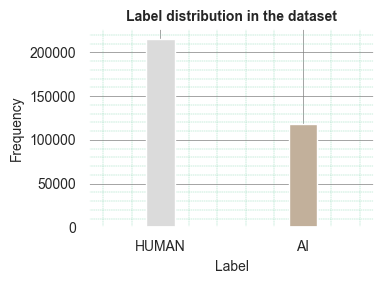

In [79]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(4, 3))
sns.countplot(data=dataframe, x="label", palette=PALETTES.coffee,
              legend=False,  fill=True, width=.2)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(f"Label distribution in the dataset", fontsize=10, weight="bold")
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

### ⚖️ Handling Class Imbalance

The dataset is sligtly **not balanced**, meaning some labels classes have significantly more examples than others.  
To ensure that **accuracy** remains a reliable performance metric, we will **downsample the majority classes** so that each labels class has approximately the same number of samples as the minority class `(Ngwenya and Garidzira, 2025)`.  

This approach helps prevent the model from becoming biased toward the majority classes and allows for a more fair evaluation of model performance.

> Ngwenya, S. and Garidzira, T.C., 2025. Enhanced Fake News Detection with Domain-Specific Word Embeddings: A TorchText-Based Method for News Semantics Representation. The Indonesian Journal of Computer Science, 14(4).


In [80]:
new_dataframe = dataframe.copy()

min_class_count = new_dataframe['label'].value_counts().min()
downsampled_list = []
for label in new_dataframe['label'].unique():
    class_df = new_dataframe[new_dataframe['label'] == label]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

### 🍰 Visualizing the Balanced Dataset

In the following code cell, we are going to **visualize the distribution** of the balanced dataset using a **pie chart**.  
This visualization helps us confirm that all label classes now have approximately equal representation after the downsampling process.


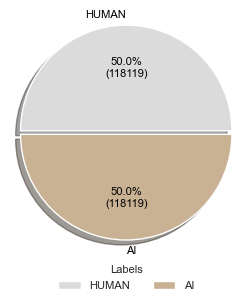

In [87]:
samples = dict(balanced_df.label.value_counts())

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.figure(figsize=(3, 3))
plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, sum(samples.values())),
    textprops={'color': 'black', 'fontsize': 8},
    radius=.6, colors=PALETTES.coffee,
    explode=[.01 for _ in range(len(samples))]
)
plt.axis('equal')
# plt.title("Labels Distribution After Balancing", fontsize=10)
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Labels", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

In [88]:
print(f"The dataset size is: {len(balanced_df):,}")

The dataset size is: 236,238


In the following code cell, we will **split the dataset into training, validation and testing sets**.  

In [89]:
train, test = train_test_split(balanced_df, test_size=0.2, random_state=SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=SEED)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

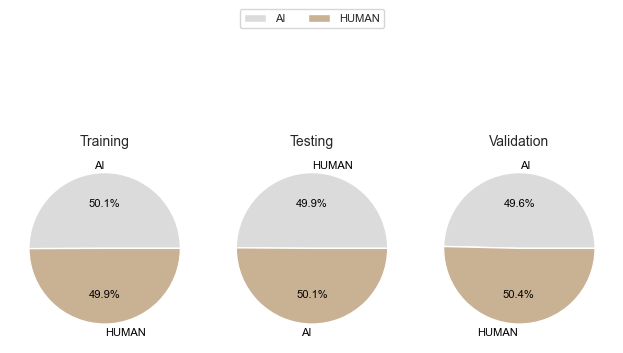

In [91]:
train_dist_label	= {i:0 for i in train.label.unique()}
for val in train.label:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test.label.unique()}
for val in test.label:
  test_dist_label[val] += 1

valid_dist_label	= {i:0 for i in valid.label.unique()}
for val in valid.label:
  valid_dist_label[val] += 1

fig, axes = plt.subplots(1, 3)

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.coffee
            )
axes[0].set_title("Training", fontsize=10)

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.coffee
            )
axes[1].set_title("Testing", fontsize=10)

axes[2].pie(valid_dist_label.values(), labels=valid_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.coffee)
axes[2].set_title("Validation", fontsize=10)

fig.legend(train.label.value_counts().index, loc="upper center", bbox_to_anchor=(0.5, 1.01), ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

In the following code cell we are going to extract features and labels for the `training`, `testing` and `validation` subsets.

In [92]:
train_texts = train.text.values
train_labels = train.label.values

test_texts = test.text.values
test_labels = test.label.values

valid_texts = valid.text.values
valid_labels = valid.label.values

Next, we will create a **Counter object** to store the word counts from the dataset.  
These counts will be used to **build our custom vocabulary** for subsequent analysis or modeling.


In [93]:
test_counter = Counter()
valid_counter = Counter()
train_counter = Counter()

for line in train_texts:
    train_counter.update(line.lower().split())

for line in test_texts:
    test_counter.update(line.lower().split())

for line in valid_texts:
    valid_counter.update(line.lower().split())

Next, we will **visualize the most common words** in the cleaned dataset using **word clouds**.

This provides an intuitive way to identify frequently occurring terms and gain insights into common patterns in essays writing styles across different categories (AI and Human).


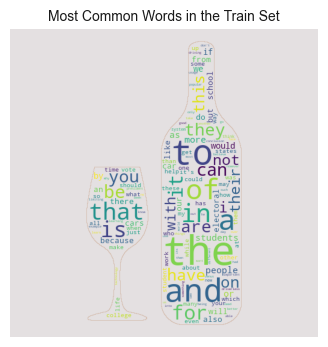

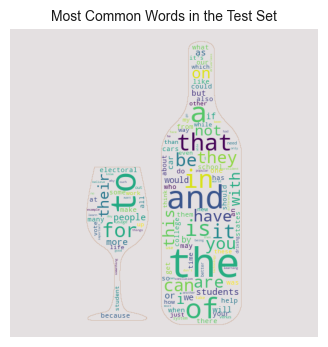

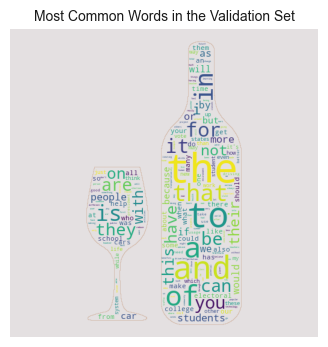

In [94]:
plot_wordcloud(
    train_counter, title="Most Common Words in the Train Set", mask="wine", figsize=(4, 4),
    fontsize=10
)
plot_wordcloud(
    test_counter, title="Most Common Words in the Test Set", mask="wine", figsize=(4, 4),
    fontsize=10
)

plot_wordcloud(
    valid_counter, title="Most Common Words in the Validation Set", mask="wine", figsize=(4, 4),
    fontsize=10
)

### 🔖 Label Pipeline

Currently, our labels are in **text format**.  
To use them in machine learning models, we need to **convert these labels into numerical values**.  

The process is straightforward:  
1. Extract all **unique labels** from the dataset.  
2. Create a `labels_vocab` mapping that represents each label as an **integer**.  

This mapping allows the model to work with numerical labels while preserving the correspondence to the original labels.


In [95]:
labels_dict = {k: v for v, k in enumerate(train.label.unique())}
labels_dict

{'AI': 0, 'HUMAN': 1}

The `label_pipeline` function takes a **text label** as input and returns its corresponding **integer representation**.  
This allows us to consistently convert all labels into numeric form for model training.


In [96]:
label_pipeline = lambda x: labels_dict[x]

### 📖 Vocabulary

Next, we will create a **Vocabulary class** and initialize it using the `counter` object.  

- We will set `min_freq = 5`, meaning any word that appears **less than 5 times** will be treated as an **unknown token**.  
- We will also specify **special tokens** (such as `<PAD>`, `<UNK>`, etc.) during the creation of the vocabulary object.  

This ensures that our vocabulary captures meaningful words while handling rare or unseen words appropriately.


In [97]:
class vocab:
    def __init__(self, counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]')):
        self.freqs = counter
        self.itos = list(specials)
        self.stoi = {}
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        self.stoi = defaultdict(lambda: self.itos.index('[unk]')) 
        for idx, token in enumerate(self.itos):
            self.stoi[token] = idx

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi[token]

    def get_stoi(self):
        return self.stoi
    def get_itos(self):
        return self.itos

vocabulary = vocab(train_counter, min_freq=5, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### 🔢 STOI - `String To Integer`

We will create a **dictionary mapping each word to a unique integer**, which will serve as our **actual vocabulary**.  

In the following code cell, we will initialize an object called `stoi` — a **word-to-index mapping**.  
This dictionary will be used both during **model training** and **inference** to convert words into numerical representations.


In [98]:
stoi = vocabulary.get_stoi()

### 📝 Text Pipeline

After tokenizing the text, we need a way to **convert words into numbers**, since machine learning models can only process numerical inputs.  

This is where the `text_pipeline` function comes in. The function:

1. Takes a **sentence** as input.  
2. Tokenizes the sentence into words.  
3. Converts each word into its corresponding **integer index** from the `stoi` vocabulary.  

**Note:** Any word not found in the vocabulary (`stoi`) will be mapped to the **unknown token** (`'[UNK]'`) with index `0`.


In [99]:
def text_pipeline(x: str):
  values = list()
  tokens = x.lower().split(" ")
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### 📊 Data

In addition to the labeled text reviews and labels, we will use **pre-trained GloVe word embeddings** to convert words into dense semantic vectors. These embeddings help capture global word co-occurrence statistics, which can improve performance in text classification and stylometry tasks.

### 🔍 How GloVe Will Be Used

- We'll download pre-trained GloVe embeddings (e.g. 100-dim or 300-dim vectors).
- Use them to convert each word in our dataset into its embedding vector.
- Possibly average (or apply more advanced aggregation) the word vectors to represent each text snippet.
- Use these embedded text vectors for exploratory data analysis (comparing essays body by vector similarity, clustering), before any classification modeling.





### 🌐 Pretrained Vectors

In the following code cell, we will download **pretrained word vectors** using `GloVe.6B.100d`.  

- These vectors were trained on approximately **6 billion words**.  
- Each word is represented as a **100-dimensional vector**, capturing semantic relationships between words.  
- Using these pretrained embeddings allows us to leverage prior knowledge of word semantics, which can improve model performance.


In [101]:
embedding_path = "C://Users//crisp//Documents//glove.6B//glove.6B.100d.txt"
EMBEDDING_DIM = 100
glove_vectors = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    glove_vectors[word] = vectors

### 🧩 Creating Embedding Matrix

Now that we have the GloVe vectors, we need to **customize them** to fit our use case.  

We will create an **embedding matrix** that aligns with our vocabulary.  
Essentially, this matrix provides a **word-to-vector mapping** for all the words in our vocabulary, allowing the model to convert each word index into its corresponding vector representation during training and inference.


In [102]:
VOCAB_SIZE = len(stoi)

EMBEDDING_MATRIX = torch.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, index in stoi.items():
    vector = glove_vectors.get(word)
    try:
        if vector is not None:
            if isinstance(vector, torch.Tensor):
                EMBEDDING_MATRIX[index] = vector
            else:
                EMBEDDING_MATRIX[index] = torch.from_numpy(vector)
        else:
            EMBEDDING_MATRIX[index] = torch.zeros(EMBEDDING_DIM)
    except (IndexError, Exception):
        continue

In [103]:
assert VOCAB_SIZE == EMBEDDING_MATRIX.size(0), "They should be the same"

In the following code cell, we will **inspect the embedding matrix** by checking the vector representation for the word `"the"`.  
This helps verify that our embeddings have been correctly mapped to the vocabulary.


In [104]:
EMBEDDING_MATRIX[stoi['the']]

tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.5106,
        -0.5203, -0.1459,  0.8278,  0.27

### 📂 Creating Dataset for Training

In the following code cell, we define a custom **dataset class** called `AIHumanDataset`.

This class takes the **essay text** and their corresponding **labels** as inputs, enabling efficient data loading, tokenization, and preprocessing for model training and evaluation.


In [115]:
class AIHumanDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(AIHumanDataset, self).__init__()
    self.text = text
    self.labels = labels

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.text)

### 🔄 `collate_fn`

We will implement a custom **collate function** named `tokenize_batch`.  
This function processes each batch of data and performs the necessary **text preprocessing steps** before the data is fed into the model. It will be passed to the `DataLoader` to efficiently handle batch preparation.

### 🔎 `tokenize_batch` Function Details

- The function takes a **batch of samples** and converts the raw text into their corresponding **integer (token) representations**.
- It **pads**, **trims**, or **truncates** sequences to a fixed length to ensure that all inputs within a batch have a uniform size.
- The function returns the processed **input features** (and corresponding labels, if applicable), ready for model training or evaluation.



In [116]:
def tokenize_batch(batch, max_len=100, position="start"):
    """
    position:
        - "start"  -> take first max_len tokens
        - "middle" -> take centered max_len tokens
        - "end"    -> take last max_len tokens
    """
    assert position in ["start", "middle", "end"], "position must be 'start', 'middle', or 'end'"
    labels_list, text_list = [], []
    for _label, _text in batch:
        labels_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
        seq_len = len(processed_text)
        text_holder = torch.zeros(max_len, dtype=torch.int32)
        
        if seq_len <= max_len:
            text_holder[:seq_len] = processed_text
        else:
            if position == "start":
                selected = processed_text[:max_len]
            elif position == "end":
                selected = processed_text[-max_len:]
            elif position == "middle":
                mid = seq_len // 2
                half = max_len // 2
                start = max(0, mid - half)
                end = start + max_len
                selected = processed_text[start:end]
            text_holder = selected
        text_list.append(text_holder.unsqueeze(0))
    
    features = torch.cat(text_list, dim=0)
    labels_tensor = (
        torch.FloatTensor(labels_list)
        if len(set(labels_list)) == 2
        else torch.LongTensor(labels_list)
    )
    return labels_tensor, features


### 📂 Datasets

In the following code cell, we will create the **datasets** for all three sets using the `AIHumanDataset` class.  
This organizes the data for **training, validation, and testing**, ensuring each set is properly prepared for model input.


In [117]:
train_dataset = AIHumanDataset(train_labels, train_texts)
test_dataset = AIHumanDataset(test_labels, test_texts)
valid_dataset = AIHumanDataset(valid_labels, valid_texts)

### 🔁 Iterators

In the following code cell, we will create **data loaders** using the `DataLoader` class from `torch.utils.data`.  
These loaders will handle **batching, shuffling, and preprocessing** of the datasets during training and evaluation. We are going to have `3` different iteratators for each subset which correspond to `start`, `middle` and `end`.


In [118]:
BATCH_SIZE = 256

# Start
train_loader_start = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader_start = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
valid_loader_start = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

# Middle
train_loader_middle = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                                  collate_fn=lambda batch: tokenize_batch(batch, position="middle"))
test_loader_middle = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                                 collate_fn=lambda batch: tokenize_batch(batch, position="middle"))
valid_loader_middle = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                                  collate_fn=lambda batch: tokenize_batch(batch, position="middle"))

# End
train_loader_end = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                                  collate_fn=lambda batch: tokenize_batch(batch, position="end"))
test_loader_end = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                                 collate_fn=lambda batch: tokenize_batch(batch, position="end"))
valid_loader_end = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                                  collate_fn=lambda batch: tokenize_batch(batch, position="end"))


### ✅ Checking a Single Batch

In this step, we will inspect a **batches of data** from the DataLoader.  
This allows us to verify that the **features and labels** are correctly processed and ready for model training.


In [119]:
lbl_start, txt_start = next(iter(train_loader_start))
lbl_end, txt_end = next(iter(train_loader_end))
lbl_middle, txt_middle = next(iter(train_loader_middle))

Checking a single batch of labels.

In [120]:
lbl_start

tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 

In [121]:
lbl_end

tensor([1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 1., 

In [122]:
lbl_middle

tensor([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 

The first sentence in the batches.

In [123]:
txt_start[0]

tensor([   0,  427,  394,  515,  291, 1861,   25,  390,  391,  262,  291, 2475,
          25,  394,   25,  411,  412,   26,   34,   28, 8171, 1039,   13, 1970,
          25,  398,  399,   25,  398,  399, 5135,   44,  444,  262,  259,   78,
          28,  391,   44,  398, 1105,    9, 2310,   28,  472,   35,  200,  382,
          18,   37,    9, 2310,   28,  472,   75,   28,  390,  391,    9,  338,
          25,  394,  401,   57,  402,  291,  395,   20,   28,  472,   65,  291,
         251,  395,   20,   28, 4518,   44,  444,   25, 1752,   75,   25,  398,
         399,   26,   64,   65,  291,   32, 1283,   25,  411,  412,  459,   28,
        2399,    9,  391,   20], dtype=torch.int32)

In [124]:
txt_middle[0]

tensor([  306,    97,   176,    42,    28,   358,    44,  2923,   940,    44,
           25,   137,    28,   358,    44,    25,  3264,  1016,   101,   128,
          874,   531,    81,   176,  4019,    28,  3508,   223,    28,   146,
          204,   176,   306,    33,   214,   320,   287,    64,   306,    97,
          176,    77,  2923,   255,   137,    11,  2964,    82,    25,  4951,
          204,   262,  1288,  1770,    77,  2923,   846,    65, 10787,   939,
         1749,    25,   204,    54,  1288,  2450,   101,   939,   991,    54,
          211,  1770,    77,  2923,  2024,    57,    77,   331,    77,    28,
        15008,   223,  1838,    28,   146,   940,    44,    25,   137,   176,
          318,   141,   137,     9,    18,    77,  3264,    97,    77,  2923],
       dtype=torch.int32)

In [125]:
txt_end[0]

tensor([   21,    44,   228,   825,    28,  1186,  1747,   259,   880,   694,
            9,  3114,  1288,   289,     9,  1751,   427,    25,   917,    44,
           25,  2073,    81,    65,   291,   323,    25,   197,    25,  1186,
          329,    32,    97,     9,  3114,   253,    44,    21,    25,   160,
          323,    25,  3486,    90,   256,    25,   686,  2394,    25,  8952,
         1003,    44,   397,   961,   351,     9,   247,    25,  2406,   223,
           25, 13209,    90,    26,   386,   176,    17,   173,    22,  1040,
          146,   293,    81,    65,   318,   141,    50,   765,  2373,    77,
          465,  2073,   176,   849,   195,   160,  3284,  1040,   304,    65,
          375,     9,  1040,  1698,    13,    25, 11444,    44,   519,  2643],
       dtype=torch.int32)

### 🧠 AIHumanCNN

In the following code cell, we will implement the **`AIHumanCNN`** model, which utilizes **1D Convolutional (Conv1D) layers** for text feature extraction and essay text classification.

Convolutional Neural Networks (CNNs) are widely recognized for their effectiveness in text classification tasks. By applying convolutional filters over word embeddings, CNNs can automatically learn local n-gram features and capture important patterns within sequences. This makes them particularly suitable for identifying sentiment-bearing phrases in long reviews.

The effectiveness of CNN architectures for sequential sentiment analysis has been demonstrated by Matobobo and Garidzira (2025).

---

### 📚 Reference

Matobobo, C., & Garidzira, T.C. (2025). *Examining 1D and 2D CNN Architectures in Comparison for Sentiment Analysis in Sequential Data: A Case Study of Spotify Music Reviews.* The Indonesian Journal of Computer Science, 14(2).


In [127]:
class AIHumanCNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
            dropout, pad_idx):
    super(AIHumanCNN, self).__init__()
    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    )
    self.convs = nn.Sequential(
        nn.ModuleList([
            nn.Conv1d(
                in_channels = embedding_dim,
                out_channels = n_filters,
                kernel_size = fs
              ) for fs in filter_sizes
        ])
    )
    self.out = nn.Sequential(
        nn.Linear(len(filter_sizes) * n_filters, output_dim)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, lenght=None):
    embedded = self.embedding(text)
    embedded = embedded.permute(0, 2, 1)
    conved = [F.relu(conv(embedded)) for conv in self.convs[0]]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.out(cat)

Next, we will create an **instance of the `AIHumanCNN`**.  

This initializes the network with the specified architecture, ready for training on our dataset.


In [128]:
FILTER_SIZES = [3, 4, 5]
INPUT_DIM = VOCAB_SIZE
EMBEDDING_DIM = 100
N_FILTERS = 128
OUTPUT_DIM = 1 if len(labels_dict) == 2 else len(labels_dict)
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']
cnn = AIHumanCNN(
 INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX
).to(device)
cnn

AIHumanCNN(
  (embedding): Sequential(
    (0): Embedding(44228, 100, padding_idx=1)
  )
  (convs): Sequential(
    (0): ModuleList(
      (0): Conv1d(100, 128, kernel_size=(3,), stride=(1,))
      (1): Conv1d(100, 128, kernel_size=(4,), stride=(1,))
      (2): Conv1d(100, 128, kernel_size=(5,), stride=(1,))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=384, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### ⚙️ Model Parameters

In the following code cell, we will **count the number of parameters** in our `AIHumanCNN` model.  
This helps us understand the **model's complexity** and the number of learnable weights.


In [129]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["CNN", *count_trainable_params(cnn)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+-------+--------------+------------------+
| MODEL | TOTAL PARAMS | TRAINABLE PARAMS |
+-------+--------------+------------------+
| CNN   |    4,577,169 |        4,577,169 |
+-------+--------------+------------------+


### 🌐 Loading Embedding Vectors

In the following code cells, we will **load the pretrained custom vectors** into the embedding layer of our model.  
We will assign the vectors that correspond to our vocabulary using:

```python
model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)
```

> This ensures that the model starts with meaningful word representations based on GloVe embeddings.

In [130]:
assert EMBEDDING_MATRIX.size(0) == VOCAB_SIZE, "This must match!"

In [131]:
cnn.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0143, -0.0241,  0.2448,  ...,  0.6469,  0.1970,  0.5882],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### ⚡ Optimizer and Criterion

We will use the **Adam optimizer** for training the model.  

For the loss function, we will use **`BCEWithLogitsLoss()`**, as this is a **binary-class classification** problem where each text sample belongs to one of several labels.


In [132]:
optimizers = {
   "cnn-middle": torch.optim.Adam(
        cnn.parameters(),
        lr=1e-3,
        weight_decay=1e-5,
        betas=(0.9, 0.999),
        eps=1e-8
    ),
    "cnn-start": torch.optim.Adam(
        cnn.parameters(),
        lr=1e-3,
        weight_decay=1e-5,
        betas=(0.9, 0.999),
        eps=1e-8
    ),
    "cnn-end": torch.optim.Adam(
        cnn.parameters(),
        lr=1e-3,
        weight_decay=1e-5,
        betas=(0.9, 0.999),
        eps=1e-8
    )
}

criterions = {
    "cnn-start": nn.BCEWithLogitsLoss().to(device),
    "cnn-middle": nn.BCEWithLogitsLoss().to(device),
    "cnn-end": nn.BCEWithLogitsLoss().to(device)
}

In the following code cell, we will create the **`binary_accuracy` function**.  
This function calculates the **binary accuracy** by comparing the predicted labels with the true labels, providing a measure of model performance for multi-class classification.


In [133]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)
     

### 🏋️ Training and Evaluation Functions

In the following code cell, we will define the **`train_fn`** and **`evaluate_fn`** functions:  

- **`train_fn`**: Handles the forward pass, loss computation, and backpropagation for model training.  
- **`evaluate_fn`**: Computes the loss and accuracy on validation or test data without updating the model weights.


In [134]:
def train_fn(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()
    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_fn(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


### 🔄 Training Loop

During model training, we will **train the model** while continuously tracking its performance.  

The following `History` class serves as a **data structure to store the training history**, including metrics such as loss and accuracy for each epoch.


In [135]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

In the following code cell, we will define the **`run_train_loop` function**.  
This function orchestrates the **entire training process**, including running the training and evaluation steps for multiple epochs and updating the training history.


In [136]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=6, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train_fn(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate_fn(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In the following code cell we are going to run the training loop for the `AIHumanCNN` model.


Let's check if the information is found at the begining?

In [137]:
EPOCHS = 20

print("============================ Are sentiments found at 'start'? =================================")
history_cnn_start, elt_cnn_start, last_saved_epoch_cnn_start = run_train_loop(
    cnn, 'cnn-start.pt', train_loader_start, test_loader_start, EPOCHS,
    optimizer=optimizers['cnn-start'], criterion=criterions['cnn-start']
)

============================ Are sentiments found at 'start'? =================================
EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.136 |    0.948 | 0:01:57.81 |
| Validation | 0.040 |    0.988 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.028 |    0.991 | 0:01:58.83 |
| Validation | 0.018 |    0.995 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.014 |    0.996 | 0:02:04.10 |
| Validation | 0.013 |    0.996 |            |
+--

Let's check if the information is at the end.?

In [138]:
print("\n\n============================ Are sentiments found at 'end'? =================================")
history_cnn_end, elt_cnn_end, last_saved_epoch_cnn_end = run_train_loop(
    cnn, 'cnn-end.pt', train_loader_end, test_loader_end, EPOCHS,
    optimizer=optimizers['cnn-end'], criterion=criterions['cnn-end']
)



============================ Are sentiments found at 'end'? =================================
EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.053 |    0.984 | 0:01:57.22 |
| Validation | 0.017 |    0.995 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.010 |    0.997 | 0:01:53.97 |
| Validation | 0.009 |    0.997 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.005 |    0.999 | 0:01:58.05 |
| Validation | 0.008 |    0.998 |            |
+--

Let's check if the infomation is at the middle.

In [139]:
print("\n\n============================ Is information found at 'middle'? =================================")
history_cnn_middle, elt_cnn_middle, last_saved_epoch_cnn_middle = run_train_loop(
    cnn, 'cnn-middle.pt', train_loader_middle, test_loader_middle, EPOCHS,
    optimizer=optimizers['cnn-middle'], criterion=criterions['cnn-middle']
)



============================ Is information found at 'middle'? =================================
EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.053 |    0.984 | 0:01:23.98 |
| Validation | 0.018 |    0.994 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.009 |    0.998 | 0:01:23.92 |
| Validation | 0.008 |    0.998 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.005 |    0.999 | 0:01:18.44 |
| Validation | 0.007 |    0.998 |            |


Next, we will **check the last saved epoch** and the **total training time** for the `CNN` models.  

This helps us understand the training duration and confirm the point at which the model was last saved.


In [140]:
rows = [
      ["CNN-start", f'{EPOCHS}', f'{last_saved_epoch_cnn_start}', f'{hms_string(elt_cnn_start)}'],
      ["CNN-middle", f'{EPOCHS}', f'{last_saved_epoch_cnn_middle}', f'{hms_string(elt_cnn_middle)}'],
      ["CNN-end", f'{EPOCHS}', f'{last_saved_epoch_cnn_end}', f'{hms_string(elt_cnn_end)}']
]
tabulate_data(["MODEL", "TOTAL EPOCHS", "LAST SAVED EPOCH", "TOTAL TRAINING TIME"]
              , rows, "MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH
+------------+--------------+------------------+---------------------+
| MODEL      | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME |
+------------+--------------+------------------+---------------------+
| CNN-start  |           20 |               11 |          0:40:01.36 |
| CNN-middle |           20 |                6 |          0:26:00.27 |
| CNN-end    |           20 |               12 |          0:38:41.37 |
+------------+--------------+------------------+---------------------+


### 📈 Training History

In the following code cells, we will **visualize the training progress** observed during model training.  

The first plot will show the **time taken to complete each epoch**, providing insights into training efficiency and computational performance.


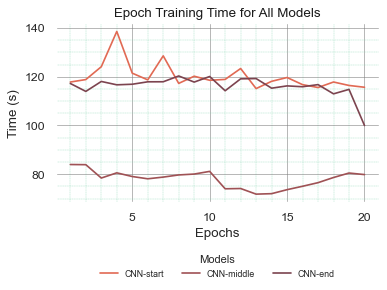

In [161]:
model_histories = {
    "CNN-start": history_cnn_start,
    "CNN-middle": history_cnn_middle,
    "CNN-end": history_cnn_end
}
colors = PALETTES.coffee[17:]
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 4), dpi=80)
for i, (model_name, history) in enumerate(model_histories.items()):
    plt.plot(
        epochs,
        history.epoch_train_time,
        color=colors[i],
        label=model_name
    )

plt.title("Epoch Training Time for All Models", fontsize=12, color="k")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)

plt.legend(
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=3, frameon=False,
    title="Models", title_fontsize=10
)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()


Next, we will **visualize the training loss** using a line graph.  

This plot shows how the loss evolved during training, helping us assess model convergence and detect potential overfitting.


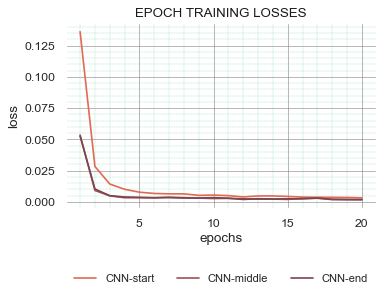

In [162]:
plt.figure(figsize=(5, 3), dpi=80)

for i, (model_name, history) in enumerate(model_histories.items()):
    plt.plot(
        epochs,
        history.train_losses,
        color=colors[i],
        label=model_name
    )

plt.title("EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()


Next, we will **visualize the validation loss** using a line graph.


This plot shows how the loss evolved during training, helping us assess model convergence and detect potential overfitting.

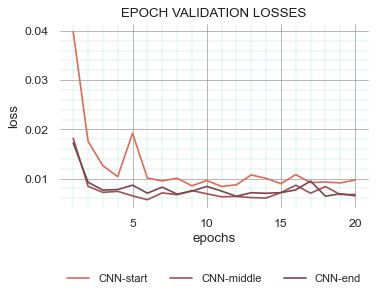

In [163]:
plt.figure(figsize=(5, 3), dpi=80)

for i, (model_name, history) in enumerate(model_histories.items()):
    plt.plot(
        epochs,
        history.val_losses,
        color=colors[i],
        label=model_name
    )
    
plt.title("EPOCH VALIDATION LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next, we will **visualize the training and validation accuracies** using a line graph.  
This plot shows how the model's accuracy evolved during training, allowing us to evaluate performance and monitor potential overfitting.


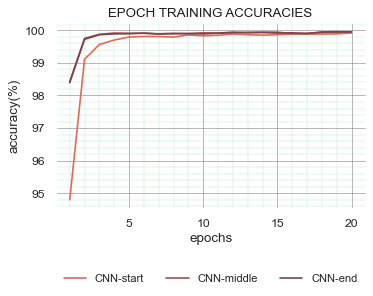

In [164]:
plt.figure(figsize=(5, 3), dpi=80)

for i, (model_name, history) in enumerate(model_histories.items()):
    plt.plot(
        epochs,
        [acc * 100 for acc in history.train_acc],
        color=colors[i],
        label=model_name
    )
plt.title("EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

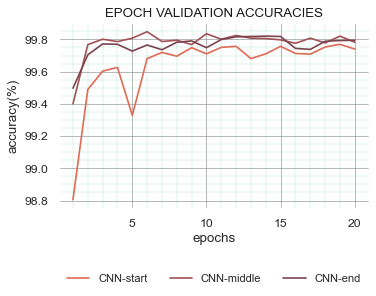

In [165]:
plt.figure(figsize=(5, 3), dpi=80)

for i, (model_name, history) in enumerate(model_histories.items()):
    plt.plot(
        epochs,
        [acc * 100 for acc in history.val_acc],
        color=colors[i],
        label=model_name
    )
plt.title("EPOCH VALIDATION ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### 🏆 Best Model Evaluations

In the following code cell, we will **evaluate the best saved model** for each architecture.  
This allows us to assess the performance of the top-performing model on the validation or test data.


In [166]:
models = {
    "CNN": cnn
}

positions = {
    "start": test_loader_start,
    "middle": test_loader_middle,
    "end": test_loader_end
}

rows = []
for model_name, model in models.items():
    for position, loader in positions.items():
        checkpoint_path = f"{model_name.lower()}-{position}.pt"
        model.load_state_dict(torch.load(checkpoint_path))
        test_loss, test_acc = evaluate_fn(
            model,
            loader,
            criterions[f"{model_name.lower()}-{position}"]
        )
        rows.append([
            f"{model_name}-{position}",
            f"{test_loss:.3f}",
            f"{test_acc * 100:.2f}%"
        ])
tabulate_data(
    ["MODEL", "TEST LOSS", "TEST ACCURACY"],
    rows,
    "POSITION-BASED MODEL EVALUATION"
)


POSITION-BASED MODEL EVALUATION
+------------+-----------+---------------+
| MODEL      | TEST LOSS | TEST ACCURACY |
+------------+-----------+---------------+
| CNN-start  |     0.008 |        99.75% |
| CNN-middle |     0.006 |        99.85% |
| CNN-end    |     0.006 |        99.82% |
+------------+-----------+---------------+


Next, we will **make predictions on the test dataset** using our trained models.  
This step allows us to see how well the model generalizes to unseen data.


In [167]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.sigmoid(y_pred).round().long()
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions


stored_results = []
for model_name, model in models.items():
    for position, loader in positions.items():
        checkpoint_path = f"{model_name.lower()}-{position}.pt"
        model.load_state_dict(torch.load(checkpoint_path))
        y_true, y_pred = get_predictions(model, loader, device)
        stored_results.append({
            "model": model_name,
            "position": position,
            "y_true": y_true,
            "y_pred": y_pred
        })


### 🧮 Confusion Matrix

In the following code cell, we will **plot the confusion matrix** for our models.  

This visualization helps us understand how well the model predicts each AI vs Human label and where misclassifications occur.


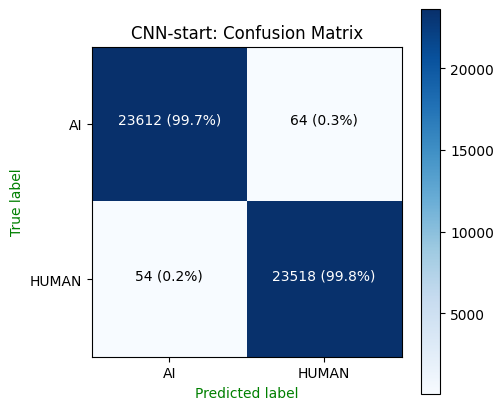

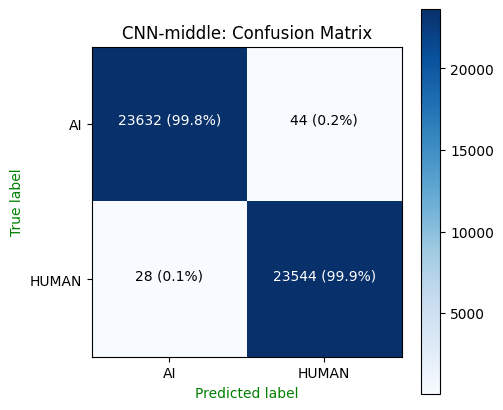

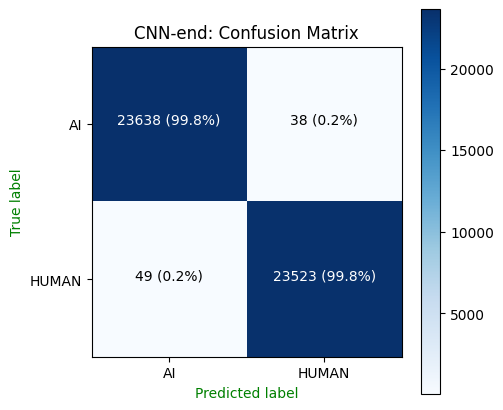

In [168]:
plt.style.use('default')
for result in stored_results:
    plot_complicated_confusion_matrix(result['y_true'], result['y_pred'],
      labels_dict.keys(), fontsize=10, figsize=(5, 5), title=f"CNN-{result['position']}: Confusion Matrix"
    )

### 📋 Classification Report

Next, we will **generate and display the classification report** for our model using the test dataset.  
This report provides metrics such as **precision, recall, F1-score, and support** for each class.


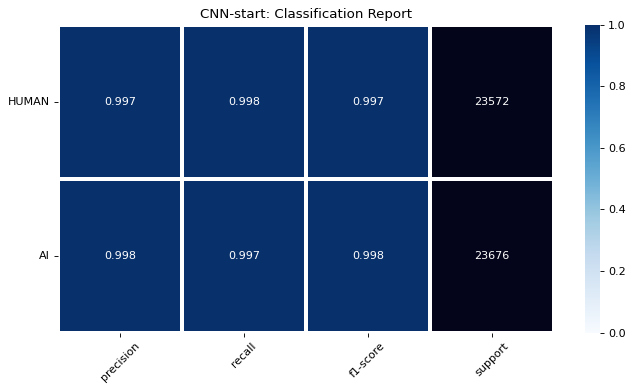

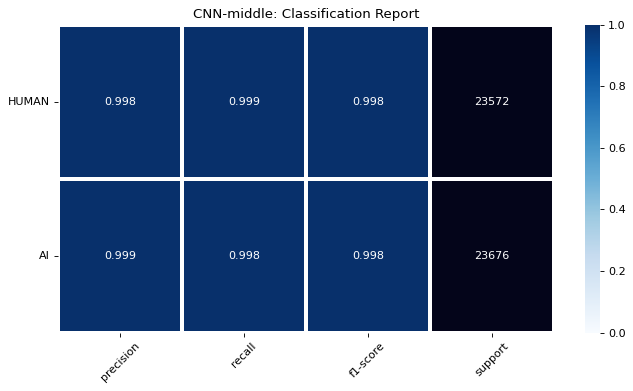

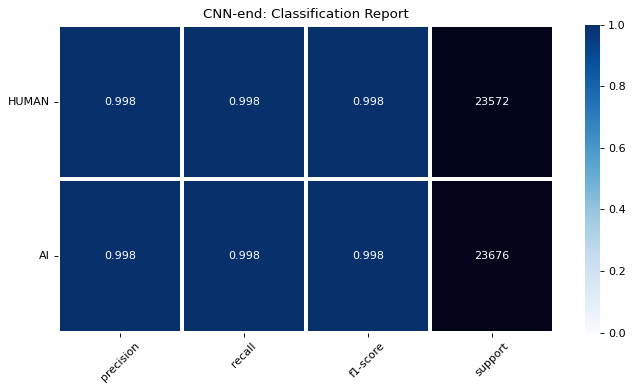

In [169]:
for result in stored_results:
    fig, ax = plot_classification_report(
        result['y_true'], result['y_pred'],
        title=f"CNN-{result['position']}: Classification Report",
        figsize=(10, 5), dpi=80,
        target_names = labels_dict.keys()
    )